# Toggle-Frame Example Problem: Single Drive

This notebook illustrates the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors for a single pauli X drive and Hadamard as the unitary goal. It's strucuted as follows:
* Imports
* Problem Setup 
* Problem Solve
* Plot fidelity swept over additive & multiplicative error 
* Save trjaectories to file

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Project.toml`
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.Pr

## Problem Setup

In [45]:
# Problem parameters
T = 40
Δt = 0.1
U_goal = exp(- 1.0im * π * PAULIS.X / 4)
Δ = 0.0 # detuning
H_drift = Δ * PAULIS.Z
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
a_bound = 2.0
dda_bound = 5.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drift, H_drive)

QuantumSystem: levels = 2, n_drives = 3

In [49]:
H_drive_var = a -> a[1] * PAULIS.X + a[2] * PAULIS.Y + a[3] * PAULIS.Z
H_vars_input = a -> PAULIS.Z
H_vars_array = Function[H_vars_input]
varsys = VariationalQuantumSystem(
    H_drive,
    [PAULIS.X, PAULIS.Y, PAULIS.Z]
)

var_prob = UnitaryVariationalProblem(
    varsys, U_goal, T, Δt;
    piccolo_options=piccolo_opts,
    robust_times=[[T]]
)

solve!(var_prob, max_iter=500, print_level=1, options=IpoptOptions(eval_hessian=false))
solve!(var_prob, max_iter=50, print_level=5, options=IpoptOptions(eval_hessian=true))

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: initial value of Ũ⃗ᵥ3
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: initial value of Ũ⃗ᵥ3
        applying constraint: final value of a
        applying constraint: bounds on a
        applying co

In [4]:
# additive error Hamiltonian
Hₑ_add = a -> PAULIS.X + PAULIS.Y + PAULIS.Z

# multiplicative error Hamiltonian
# X_drive = sys.H.H_drives[1]
# Hₑ_mult = a -> a[1] * X_drive

# no robustness
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(default, max_iter=200, print_level=5)

# additive robustness
add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=1.0
        )
solve!(add_prob, max_iter=200, print_level=5)

# multiplicative robustness
# mult_prob = UnitarySmoothPulseProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts,
#     activate_rob_loss=true,
#     H_err=Hₑ_mult,
#     Q_t=1.0
# )
# solve!(mult_prob, max_iter=200, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear sol

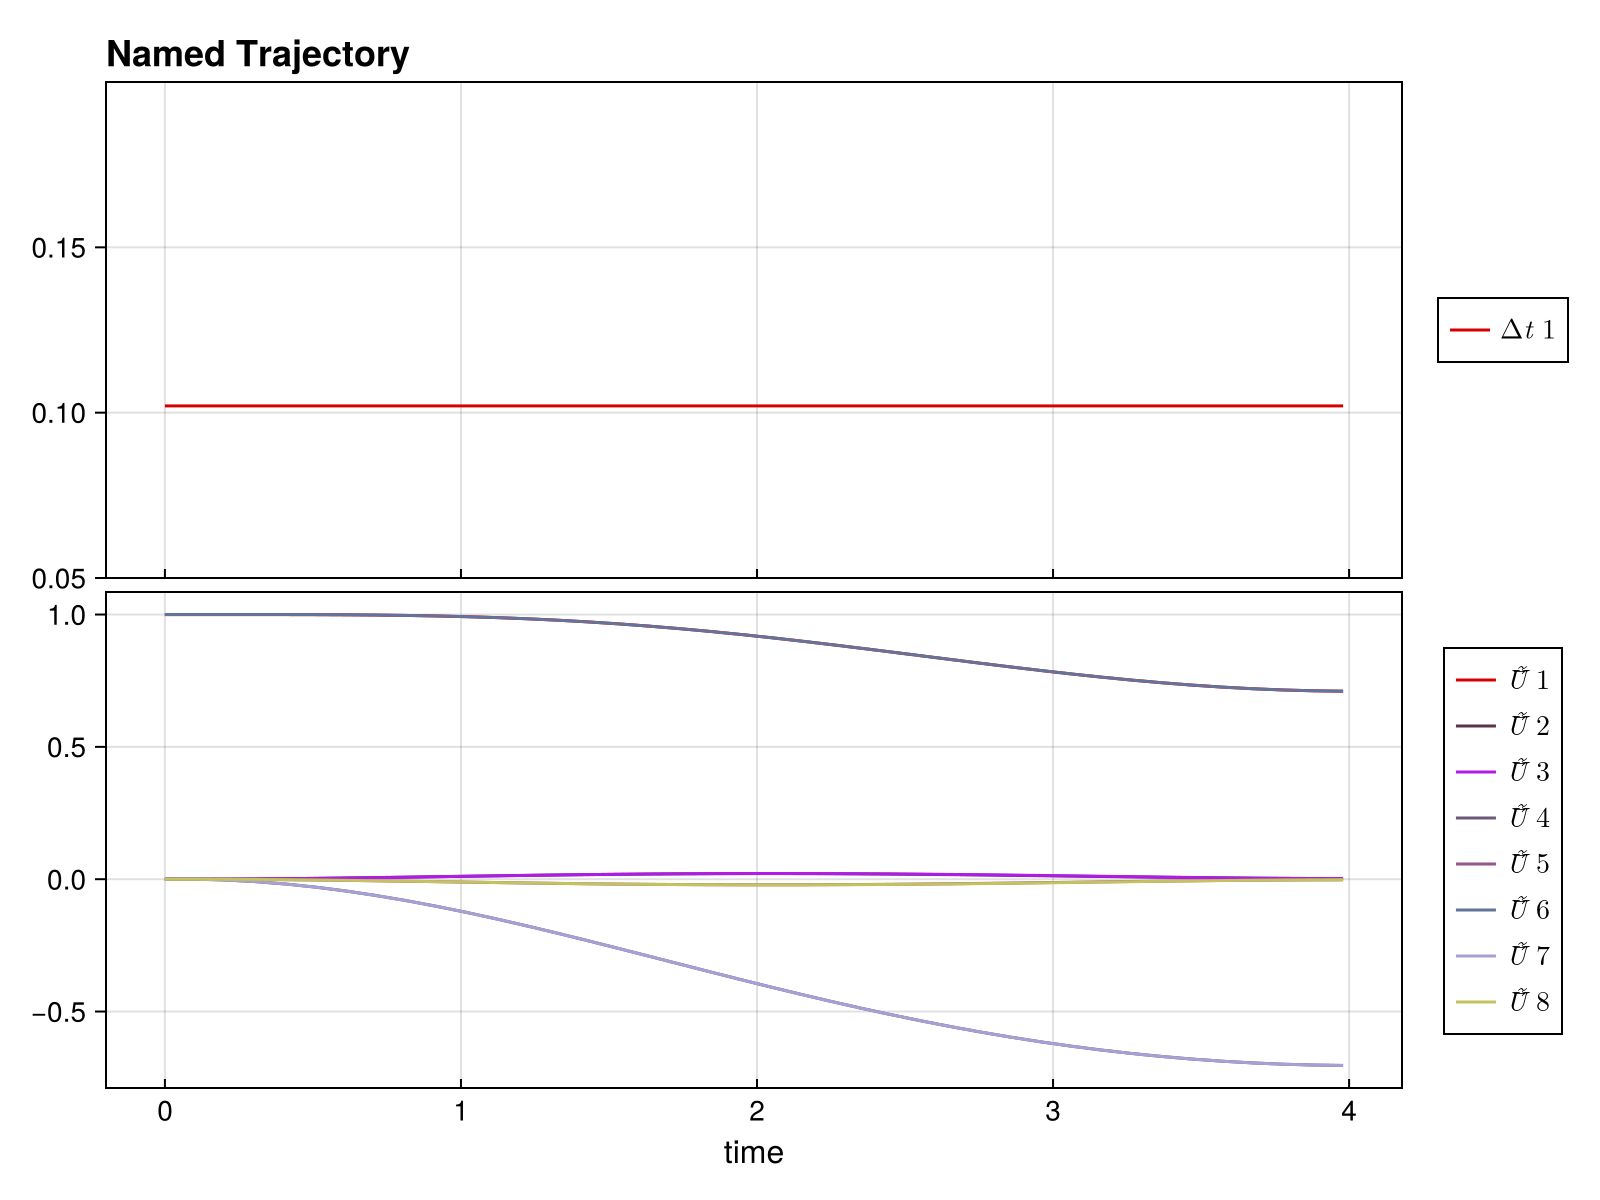

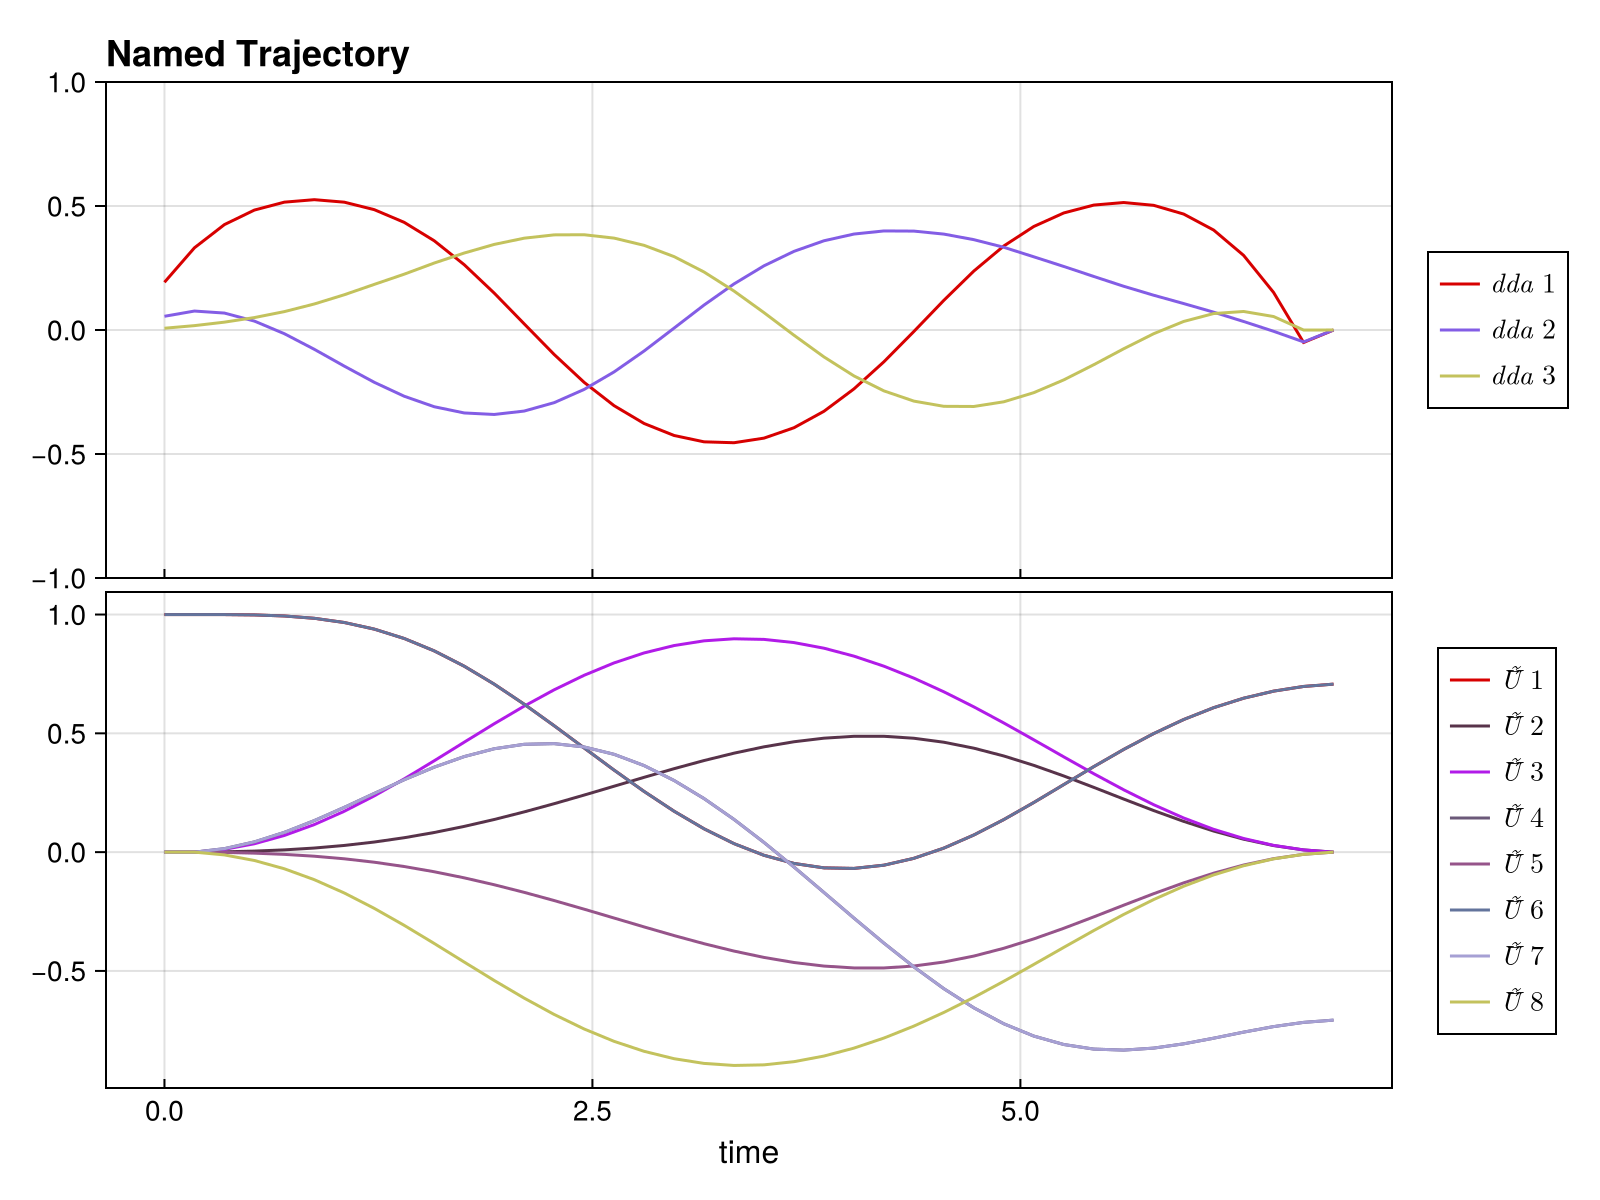

CairoMakie.Screen{IMAGE}


In [13]:
p1 = CairoMakie.plot(default.trajectory, [:Δt, :Ũ⃗])
#p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:dda, :Ũ⃗])

display(p1)
display(p2)
#display(p3)

#### Plotting

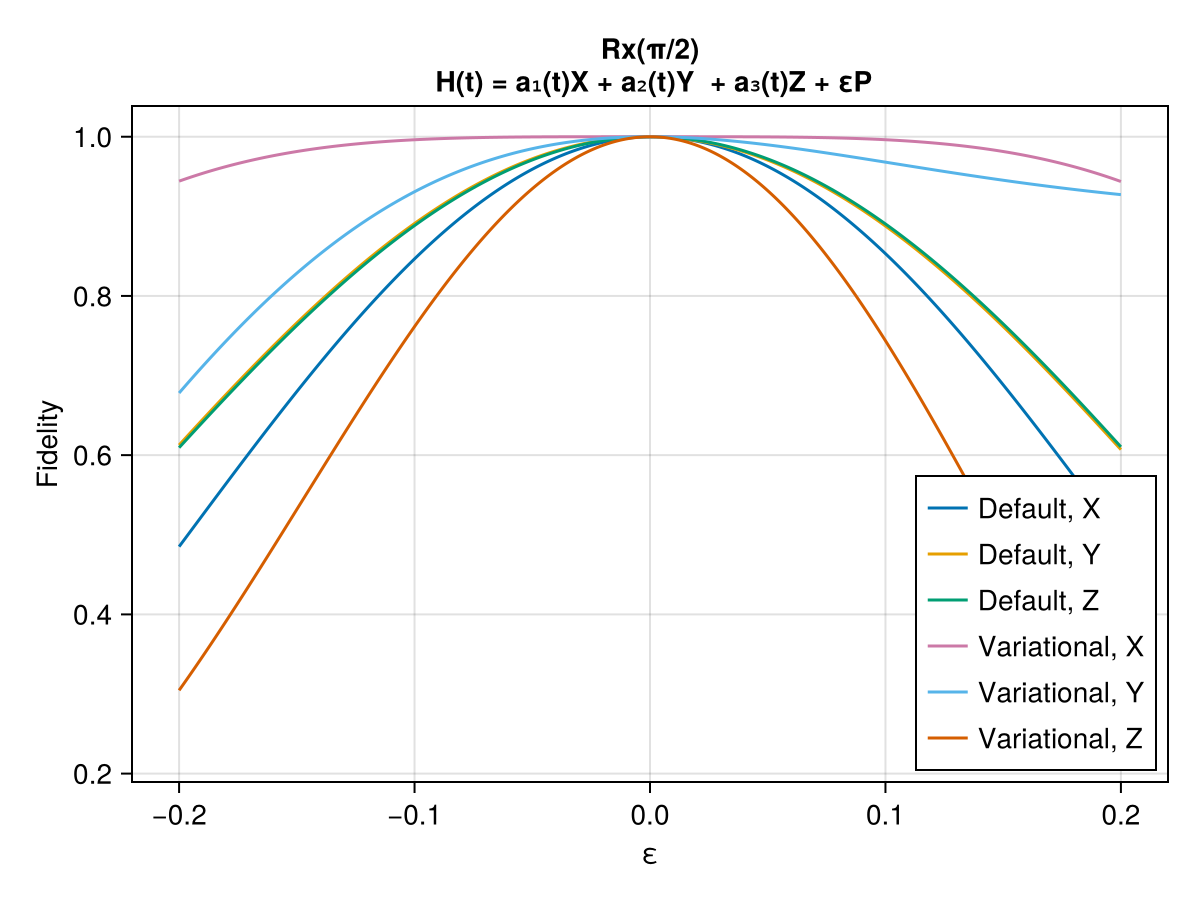

In [50]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1],
    title = "Rx(π/2)\n H(t) = a₁(t)X + a₂(t)Y  + a₃(t)Z + εP",
    xlabel = "ε",
    ylabel = "Fidelity"
)
#ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = -.2:0.001:.2

# default case (smooth, non-variational, w/o toggling obj)
ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, X", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.Y + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, Y", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, Z", color=colors[3], linestyle=:solid)

# ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="Robust", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, X", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.Y + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, Y", color=colors[5], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, Z", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

axislegend(ax1; position = :rb, tellwidth = false, tellheight = false)
#Legend(f[2,2], ax2, position=:lb)

f


In [51]:
add_traj = var_prob.trajectory
default_traj = default.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [52]:
add_curve = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

40-element Vector{Vector{Float64}}:
 [0.0, 0.0, 2.0]
 [1.13013569136643e-30, 9.90784222657528e-32, 4.0]
 [-0.0013147662041742307, 0.012379861481729516, 5.9999612523496975]
 [-0.005223196127123659, 0.04931615800153486, 7.999616332227905]
 [-0.012940034501163489, 0.12260558917306907, 9.998258152768525]
 [-0.025591789737537497, 0.24350716105171794, 11.994560432048576]
 [-0.0441946468384138, 0.42259725554076377, 13.986439137510875]
 [-0.06963333257342327, 0.6696335634153227, 15.970960777865209]
 [-0.10264084282009915, 0.9934271704041162, 17.944300223127975]
 [-0.1437796173939367, 1.4017240212303355, 19.901748019746357]
 ⋮
 [-2.1177137482959862, 32.3681805548951, 46.967511423873674]
 [-2.1687631126761913, 34.34998621642181, 47.231931638379606]
 [-2.2116594906811624, 36.339104375716026, 47.43602110471293]
 [-2.2468771441450612, 38.333057686225516, 47.58767541913261]
 [-2.2751408232656374, 40.32999003887968, 47.69517576885959]
 [-2.297426708092561, 42.328596776120406, 47.767096183387764]
 [-2

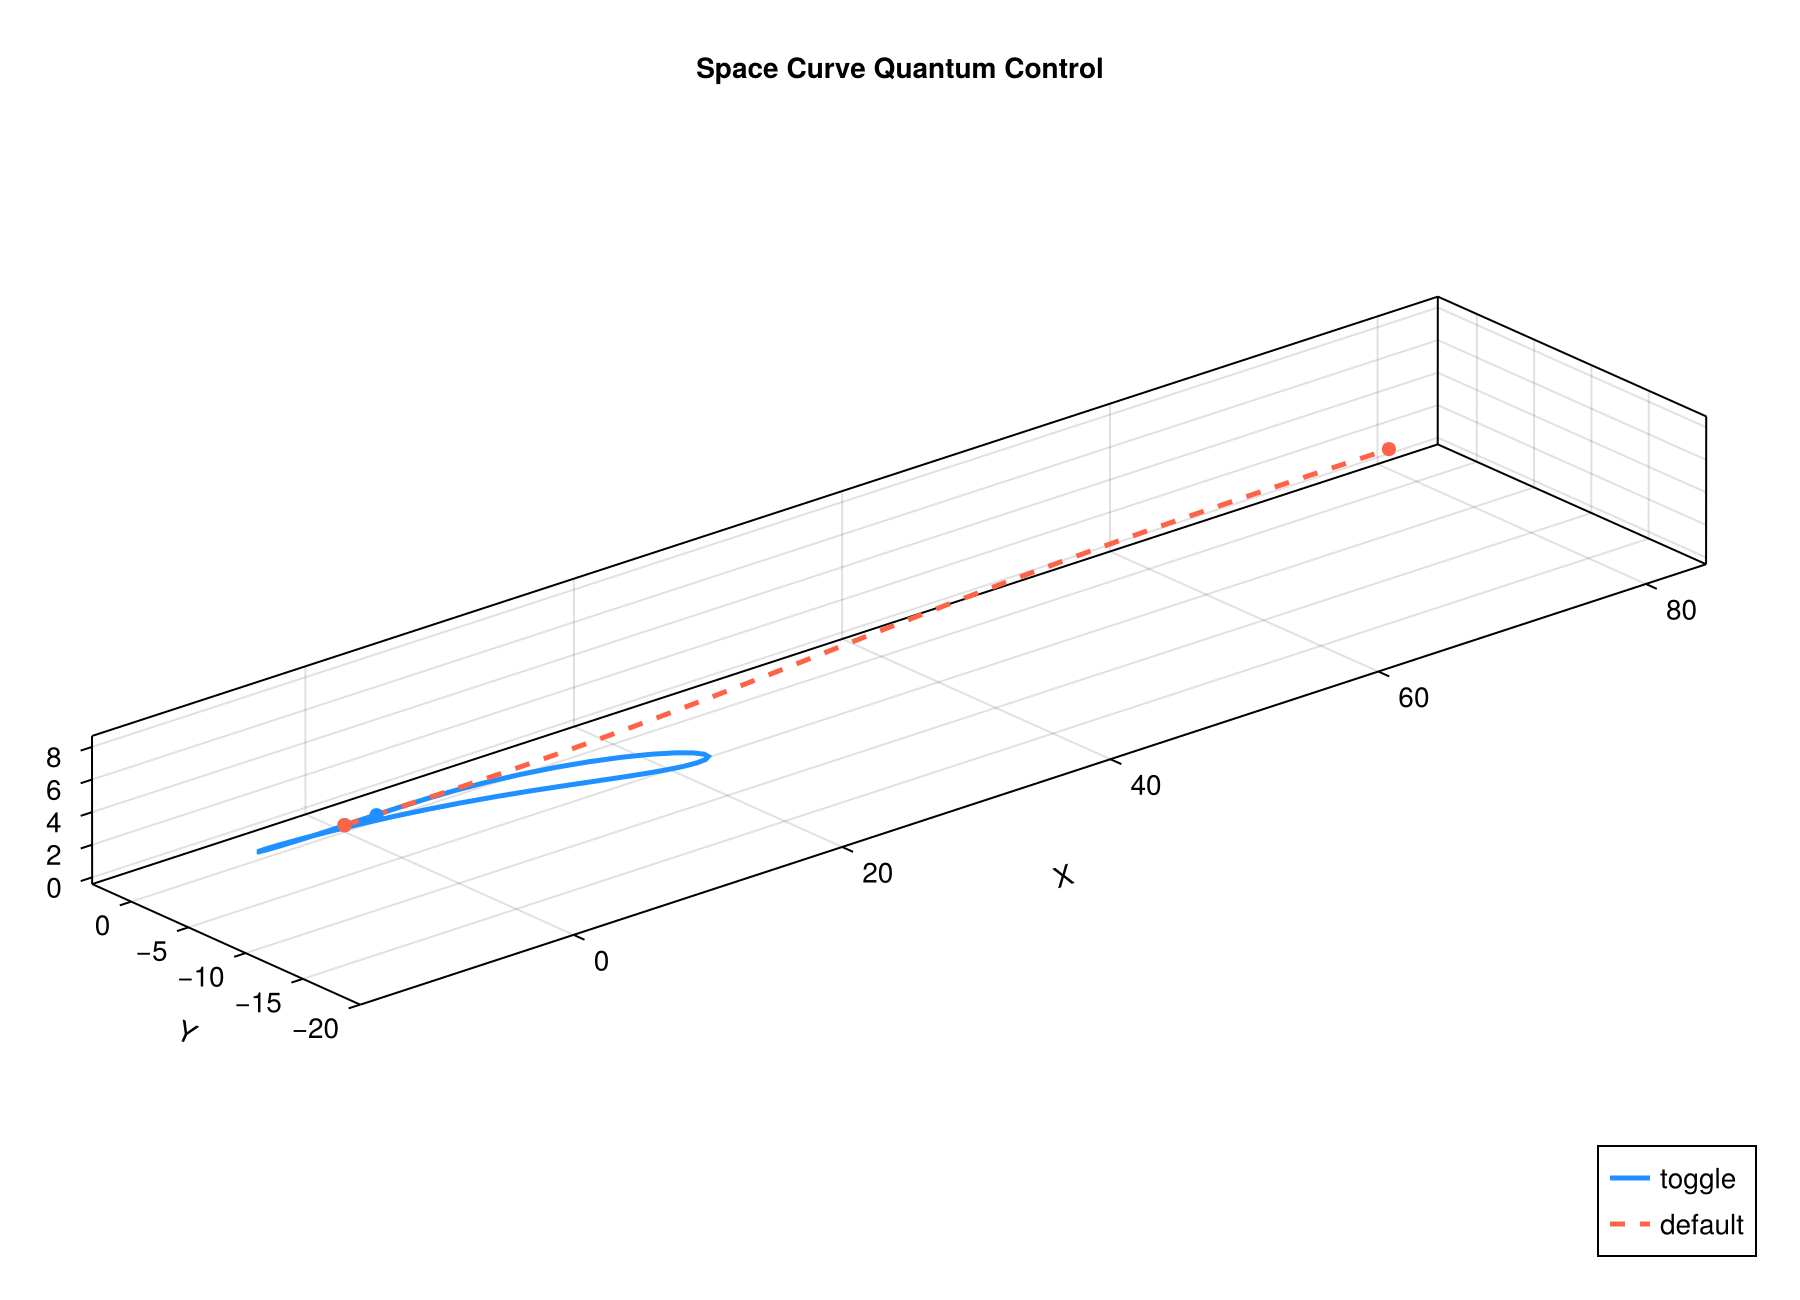

CairoMakie.Screen{IMAGE}


In [53]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

Hₑ = PAULIS.X

add_curve     = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(add_curve)
x2, y2, z2 = to_xyz(default_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "toggle")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)

CM.axislegend(ax; position = :rb)

display(f)


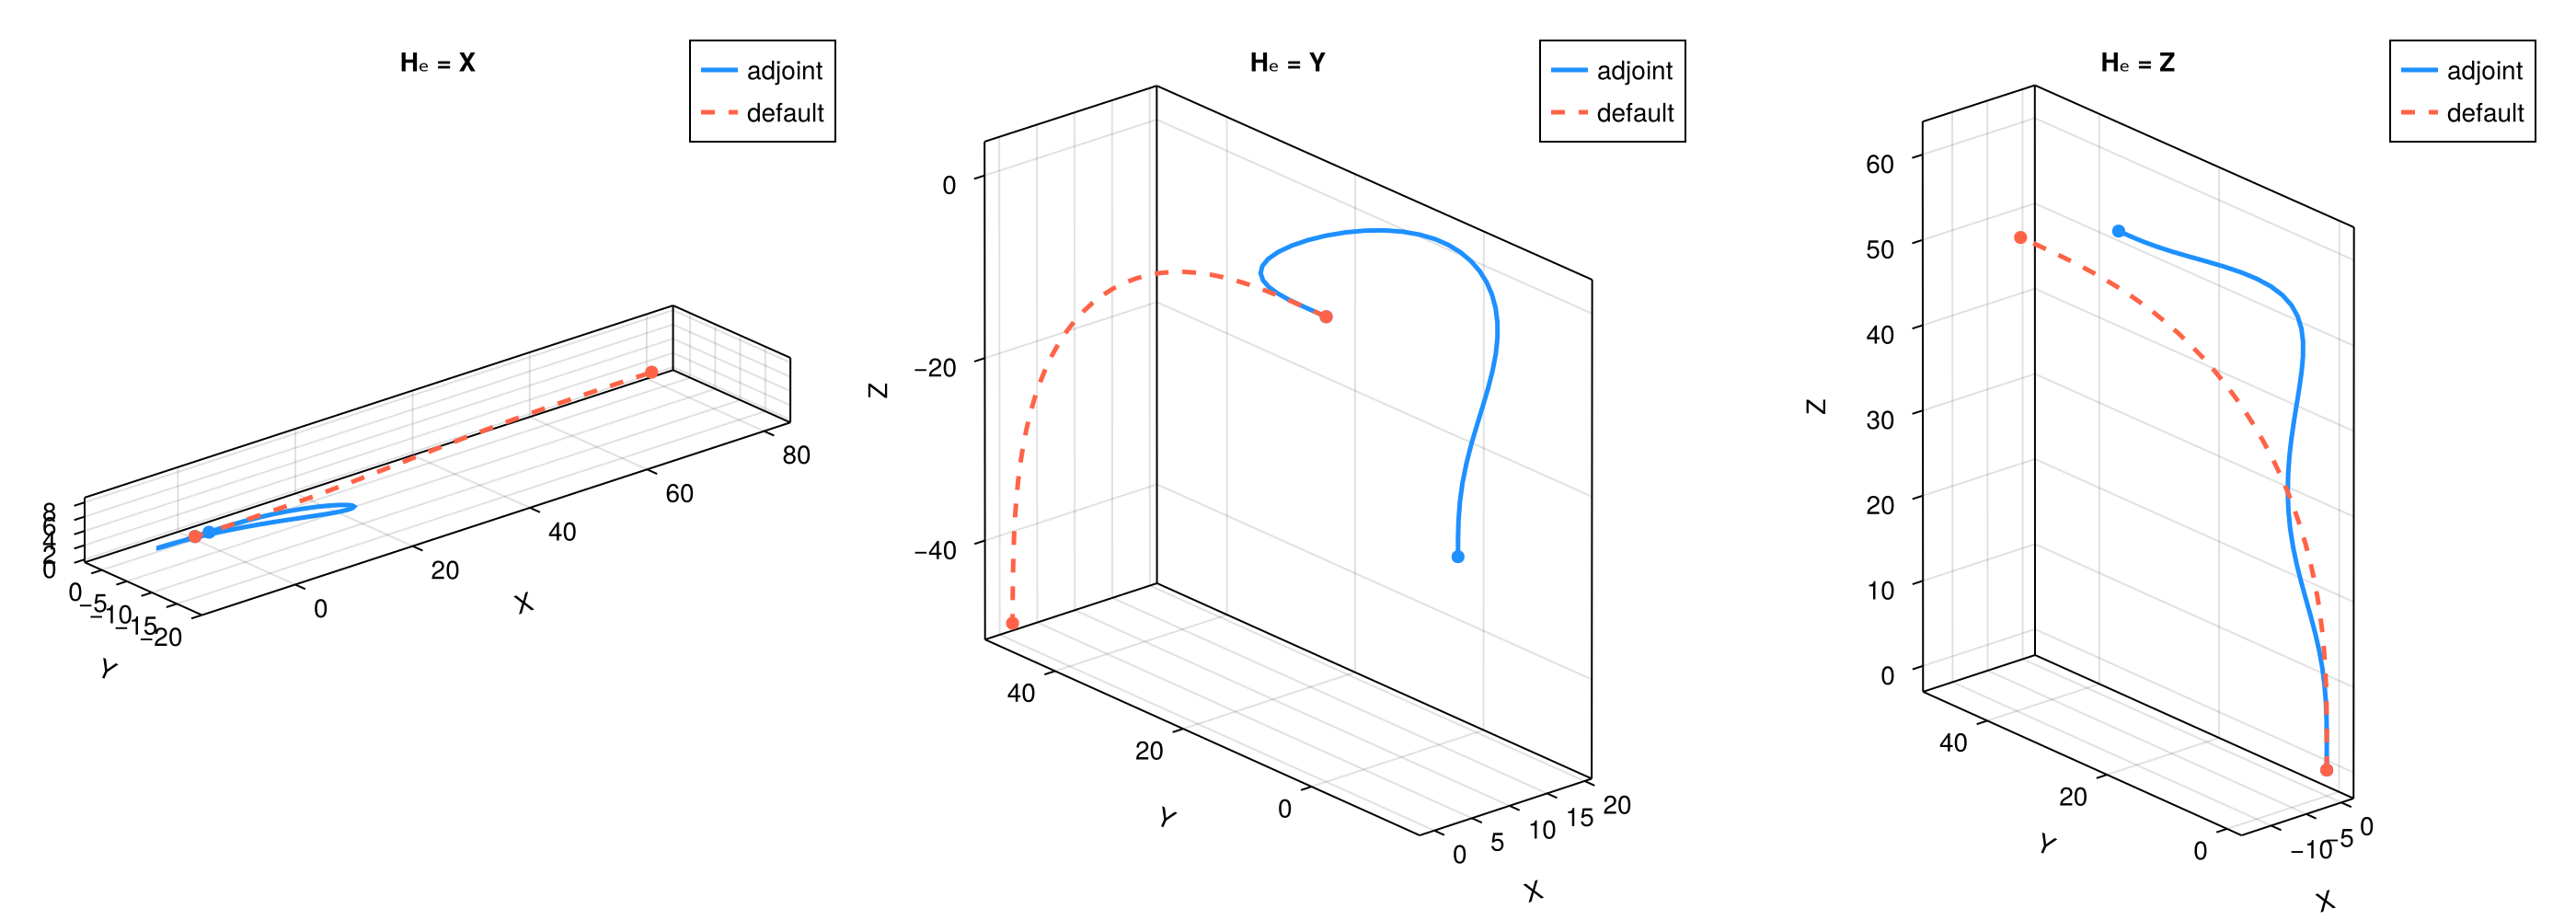

CairoMakie.Screen{IMAGE}


In [54]:
using CairoMakie
const CM = CairoMakie

# assume to_xyz, add_traj, default_traj, U_goal already defined

function curves_for(He_sym)
    # IMPORTANT: if SpaceCurve reads the global Hₑ, update it here
    global Hₑ = He_sym
    add_curve     = SpaceCurve(add_traj,     U_goal, He_sym)
    default_curve = SpaceCurve(default_traj, U_goal, He_sym)
    return add_curve, default_curve
end

function plot_pair!(pos, He_sym, ttl)
    add_curve, default_curve = curves_for(He_sym)

    x1,y1,z1 = to_xyz(add_curve)
    x2,y2,z2 = to_xyz(default_curve)

    pushfirst!(x1,0.0); pushfirst!(y1,0.0); pushfirst!(z1,0.0)
    pushfirst!(x2,0.0); pushfirst!(y2,0.0); pushfirst!(z2,0.0)

    ax = CM.Axis3(pos; xlabel="X", ylabel="Y", zlabel="Z", title=ttl, aspect=:data)
    CM.lines!(ax, x1,y1,z1; linewidth=2.5, color=:dodgerblue, label="adjoint")
    CM.lines!(ax, x2,y2,z2; linewidth=2.5, linestyle=:dash, color=:tomato, label="default")
    CM.scatter!(ax, [x1[1]], [y1[1]], [z1[1]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x1[end]], [y1[end]], [z1[end]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x2[1]], [y2[1]], [z2[1]]; markersize=10, color=:tomato)
    CM.scatter!(ax, [x2[end]], [y2[end]], [z2[end]]; markersize=10, color=:tomato)
    CM.axislegend(ax; position=:rt)
    return ax
end

f = CM.Figure(size=(1400, 500))
plot_pair!(f[1,1], PAULIS.X, "Hₑ = X")
plot_pair!(f[1,2], PAULIS.Y, "Hₑ = Y")
plot_pair!(f[1,3], PAULIS.Z, "Hₑ = Z")
display(f)

In [34]:
ket_0 = [1.0,0.0]

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(PAULIS.X * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_y = [real(tr(PAULIS.Y * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_z = [real(tr(PAULIS.Z * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_x_1 = [real(tr(PAULIS.X * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(PAULIS.Y * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(PAULIS.Z * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]


40-element Vector{Float64}:
 1.0
 1.0
 0.9999806261748483
 0.9998275399391037
 0.99932091027031
 0.9981511396400244
 0.9959393527311479
 0.9922608201771661
 0.9866697226313822
 0.9787238983091903
 ⋮
 0.16608254097853514
 0.132210107252965
 0.10204473316666007
 0.07582715720983946
 0.05375017486349021
 0.035960207264084276
 0.022559605246239123
 0.013609966108138027
 0.009136961980112435

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/scenes.jl:238
┌ Warning: `shading = true` is not valid. Use `Makie.automatic`, `NoShading`, `FastShading` or `MultiLightShading`. Defaulting to `MakieCore.Automatic()`.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/lighting.jl:243


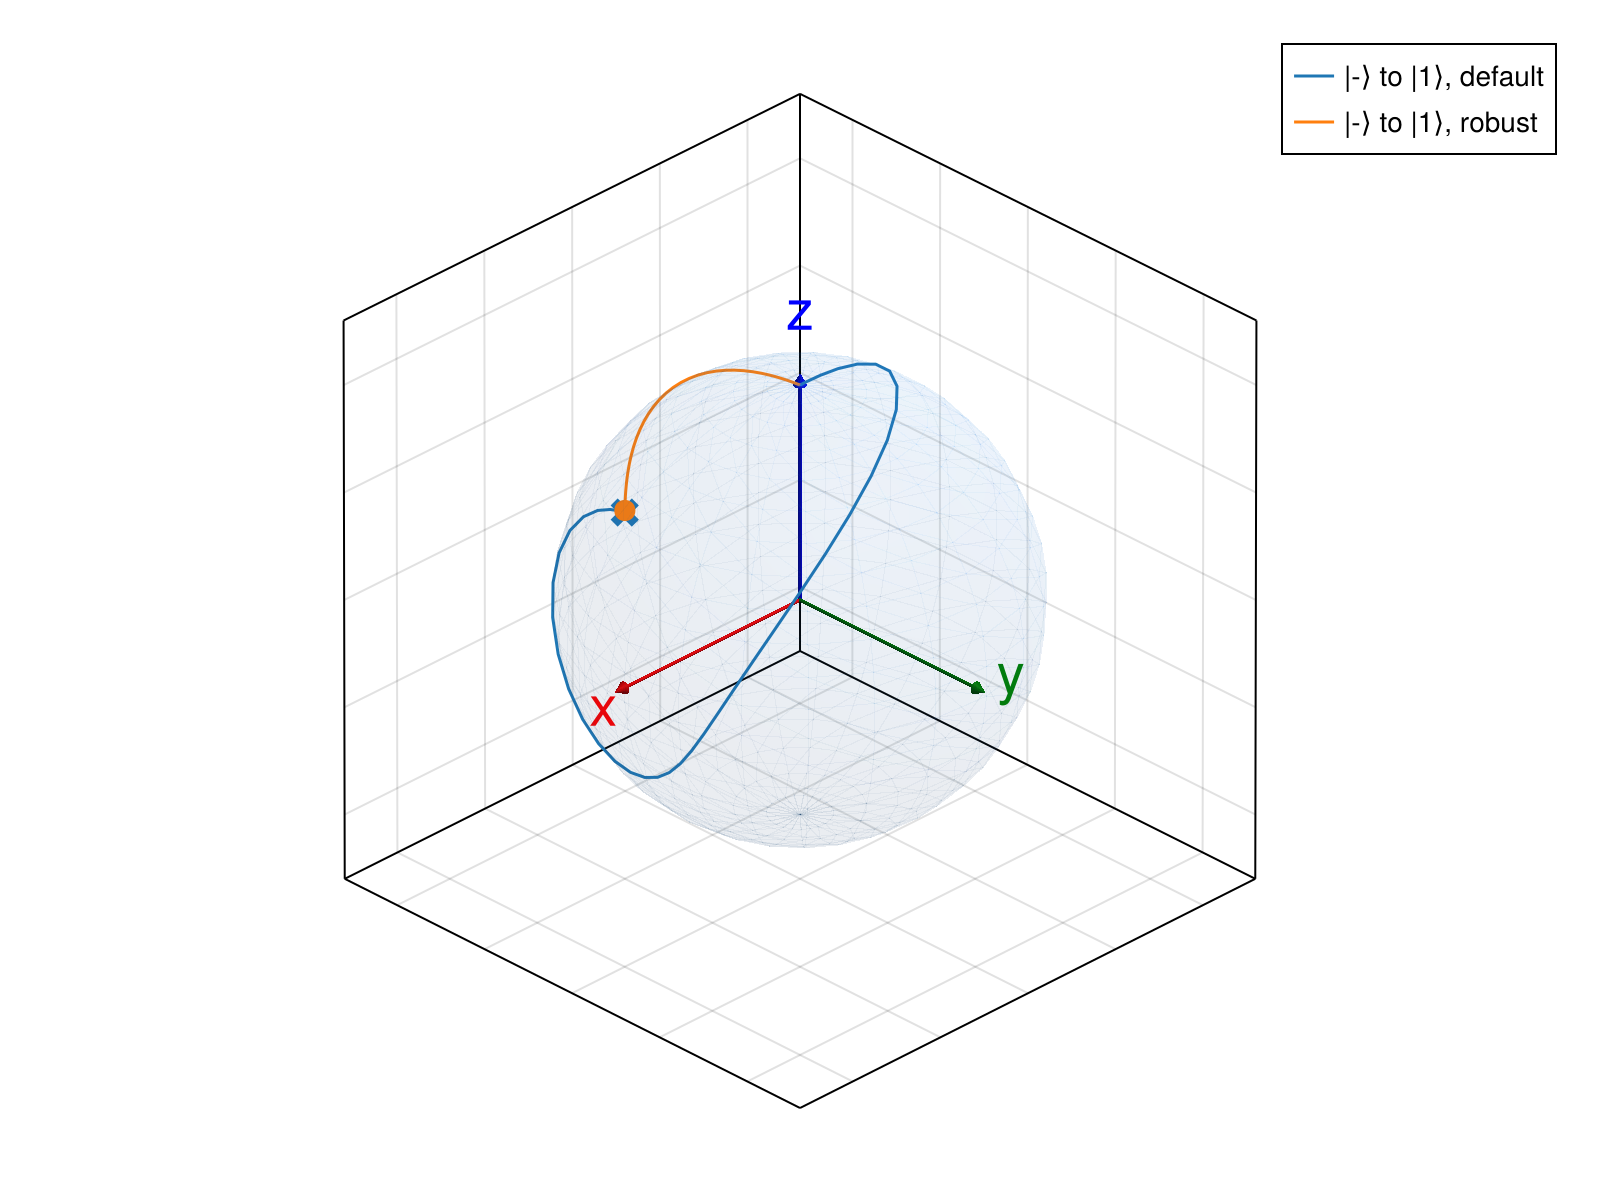

In [35]:
using CairoMakie          # Makie backend + plotting API
using GeometryBasics      # for Point3f/Vec3f

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

# --- axis arrows -------------------------------------------------------------
origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]  # arrows unchanged

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

# Labels placed further than tip, font bigger
CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

# --- trajectory --------------------------------------------------------------
CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

# --- translucent unit sphere -------------------------------------------------
CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

# --- cosmetics ---------------------------------------------------------------
CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

# CairoMakie.save("exact_1.png", f)
f

In [11]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs add_traj mult_traj fid_traces meta
